# 1) Getting Familiar With BLIP

## 1.1) Preparation

In [1]:
from utils import *
import torch
from models.blip import blip_decoder
from torch.nn import CrossEntropyLoss

In [2]:
# set hyperparameters
IMG_SIZE = 384
MODEL_PATH = "./pretrained_weights/model_base_caption_capfilt_large.pth"
IMG_PATH = "./imgs/demo.jpg"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Selected device: {DEVICE.type}")

Selected device: cuda


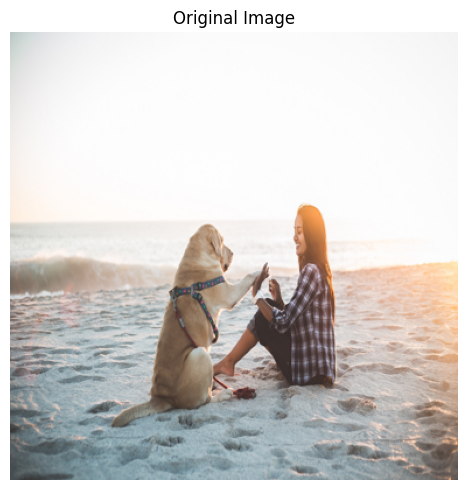

In [3]:
# prepare and display the img
img = preprocess_img(IMG_PATH, IMG_SIZE)
img = img.to(DEVICE)
img_norm = normalize(img)
display_img(orig_img_tensor=img)

In [4]:
# load BLIP image-to-caption model
model = blip_decoder(pretrained=MODEL_PATH, image_size=IMG_SIZE, vit='base')
model.eval()
model = model.to(DEVICE)

load checkpoint from ./pretrained_weights/model_base_caption_capfilt_large.pth


In [5]:
# print number of parameters in the model
num_of_parm(model)

Total parameters: 223.97M


## 1.2) Generate Caption

In [6]:
# generate caption for the img (with beam search)
with torch.no_grad():
    caption = model.generate(img_norm, sample=False, num_beams=3, max_length=20, min_length=5)[0]
    print(caption)

a woman sitting on the beach with a dog


## 1.3) Rewriting the Generate Method to Gain a Better Intuition About the Model

In [6]:
def custom_generate(model, image, max_length=30):
    
    tokenizer = model.tokenizer
    image_embeds = model.visual_encoder(image)  # generating image embeddings using the ViT encoder

    # initial input IDs
    input_ids = tokenizer([model.prompt], return_tensors="pt").input_ids.to(DEVICE)
    input_ids[:, 0] = tokenizer.bos_token_id  # add 'beginning of sentence' token
    input_ids = input_ids[:, :-1] # remove 'end of sentence' token
    
    # create the encoder attention mask
    image_atts = torch.ones(image_embeds.size()[:-1],dtype=torch.long).to(image.device)

    # autoregressive loop
    for _ in range(max_length):
        # generate the next token using the image embeddings and previous text sequence 
        outputs = model.text_decoder(input_ids=input_ids, encoder_hidden_states=image_embeds, encoder_attention_mask=image_atts)
        next_token_logits = outputs.logits[:, -1, :]  # logits of the last token
        next_token_id = next_token_logits.argmax(dim=-1).unsqueeze(-1)  # greedy search

        if next_token_id == tokenizer.sep_token_id:  # check for 'end of sentence' token
            break
        
        input_ids = torch.cat([input_ids, next_token_id], dim=-1)  # append the new token to the sequence

    final_caption = tokenizer.decode(input_ids[0], skip_special_tokens=True)  # decode the final sequence
    final_caption = final_caption[len(model.prompt):]  # remove initial prompt 
    
    return final_caption

In [7]:
# generate caption for the img (vanilla)
with torch.no_grad():
    caption = custom_generate(model, img_norm)
    print(caption)

a woman sitting on the beach with a dog


## 1.4) Rewriting the Loss Function to Better Understand It

In [8]:
# it's exactly the same as original forward method buy here we return decoder_output instead of the loss
def custom_forward(model, image, caption):
    image_embeds = model.visual_encoder(image) 
    image_atts = torch.ones(image_embeds.size()[:-1],dtype=torch.long).to(image.device)
    
    text = model.tokenizer(caption, padding='longest', truncation=True, max_length=40, return_tensors="pt").to(image.device) 
    text.input_ids[:,0] = model.tokenizer.bos_token_id
    decoder_targets = text.input_ids.masked_fill(text.input_ids == model.tokenizer.pad_token_id, -100)         
    decoder_targets[:,:model.prompt_length] = -100
 
    decoder_output = model.text_decoder(text.input_ids, 
                                        attention_mask = text.attention_mask, 
                                        encoder_hidden_states = image_embeds,
                                        encoder_attention_mask = image_atts,                  
                                        labels = decoder_targets,
                                        return_dict = True,   
                                       ) 
    
    return decoder_output

In [9]:
caption = model.prompt + "a woman sitting on the beach with a dog"

decoder_output = custom_forward(model, img_norm, caption)
out_logits = decoder_output.logits.squeeze(0)
seq_len, vocab_size = out_logits.shape
print(f"The caption has a sequence length of {seq_len} tokens, and the total vocabulary size is {vocab_size} tokens.")

The caption has a sequence length of 14 tokens, and the total vocabulary size is 30524 tokens.


![formula](./assets/formulas/1.png)

In [10]:
# tokenize the caption
token_ids = model.tokenizer([caption], return_tensors="pt").input_ids.to(DEVICE).squeeze(0)
# mask padding tokens to be ignored by the loss function
token_ids = token_ids.masked_fill(token_ids == model.tokenizer.pad_token_id, -100)
# mask prompt tokens to be ignored by the loss function
token_ids[:model.prompt_length] = -100

# shifting to align out_logits and token_ids
logits = out_logits[:-1, :]  # slicing off the last logit
labels = token_ids[1:]  # slicing off the first label

loss_fn = CrossEntropyLoss(reduction='mean', label_smoothing=0.1)
loss = loss_fn(logits, labels)

print(f"Manually calculated loss: {loss.item():.4f}")
print(f"Provided loss through decoder output: {decoder_output.loss.item():.4f}")

Manually calculated loss: 1.8529
Provided loss through decoder output: 1.8529


**NOTE:** While one might expect standard CE loss (without label smoothing) to yield stronger adversarial examples, in practice CE with label smoothing performed slightly better, likely because the model was trained with smoothing and its gradients align more naturally with that objective.  
Therefore, in the following experiments, **we compute the loss using the model’s original forward function**, which returns CE loss with label_smoothing=0.1.